# Indexing

## Loading documents

In [14]:
import bs4
from typing import Literal
from pydantic import BaseModel
from dotenv import load_dotenv
from typing_extensions import Annotated
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.embeddings import DashScopeEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import PydanticOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter

load_dotenv()

True

In [6]:
# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [7]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Splitting documents

In [8]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


## Storing documents

In [9]:
embeddings = DashScopeEmbeddings(model="text-embedding-v3")

In [10]:
vector_store = InMemoryVectorStore(embeddings)

In [11]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

['fbacab37-e9f6-494c-a9ea-7fe2cf416129', '243578fb-dd82-4feb-bfa2-da3d8a8a158b', '4afdd403-efbb-4fac-8214-33db3dd8d018']


# Retrieval and Generation

In [24]:
prompt = PromptTemplate.from_template("""ou are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
""")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

ou are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here)
Context: (context goes here)
Answer:



In [25]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [26]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="qwen-plus")

In [27]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [28]:
from langgraph.graph import START, StateGraph, END

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

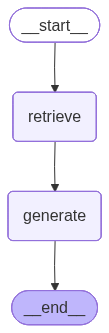

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
result = graph.invoke({"question": "What is Task Decomposition? 请用中文回答。"})

In [33]:
print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='97cf4e04-7f80-4175-9b2a-cdc71864cae1', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

# Query analysis

In [34]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [35]:
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [36]:
class Search(BaseModel):
    """Search query."""

    query: Annotated[
        str, ..., "The search query to be executed. Note that it should not contain any section-specific information."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [37]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    parser = PydanticOutputParser(pydantic_object=Search)
    tagging_prompt = ChatPromptTemplate.from_template(
        """
        Extract the desired information from the following passage.

        Wrap the output in `json` tags\n{format_instructions}

        Passage:
        {input}
        """).partial(format_instructions=parser.get_format_instructions())
    chain = tagging_prompt | llm | parser
    result = chain.invoke(state["question"])
    return {"query": result}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query.query,
        filter=lambda doc: doc.metadata.get("section") == query.section,
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

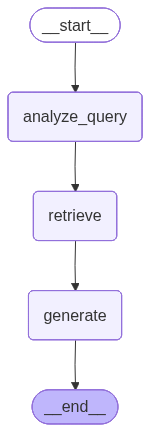

In [38]:
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
for step in graph.stream(
        {"question": "What does the beginning of the post say about Task Decomposition?"},
        stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': Search(query='Task Decomposition', section='beginning')}}

----------------

{'retrieve': {'context': [Document(id='d6b8f102-5fd9-40fe-afe9-3631d0207a55', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638, 'section': 'beginning'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes th